# Regression with Neural Net using Tensorflow

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

In [4]:
# --- defining the Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise

X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

In [7]:
N = 500
learning_rates = np.logspace(-4, -1, N)
scores = np.zeros(N)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(hidden_layer_sizes=(50,), 
                            max_iter=500, 
                            random_state=2024, 
                            learning_rate_init=0.1, 
                            batch_size=500, 
                            activation='logistic'))
])

pipeline.fit(X_train, z_train)
pipeline.score(X_test, z_test)

0.9736649483502982

In [ ]:
X_train.fit_transform()
X_test.transform()

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(13, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

  
if __name__ == '__main__':
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Load Boston dataset
  X, y = load_boston(return_X_y=True)
  
  # Prepare Boston dataset
  dataset = BostonDataset(X, y)
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
  
  # Initialize the MLP
  mlp = MLP()
  
  # Define the loss function and optimizer
  loss_function = nn.L1Loss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
  
  # Run the training loop
  for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 10 == 0:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

  # Process is complete.
  print('Training process has finished.')

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Define the neural network
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNet, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    # defining the forward pass
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))      # relu activation
        x = self.output(x)                  # 'identity' activation
        return x

# Assuming_train and z_train are your training data and target values
input_size = X_train.shape[1] 
hidden_size = 50  
output_size = 1  

# Initialize the model, loss function, and optimizer
model = RegressionNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Standardize the data and convert to Pytorch tensors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
z_train_tensor = torch.tensor(z_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
z_test_tensor = torch.tensor(z_test, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, z_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, z_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, z_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}')

# Evaluate the model on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    test_loss = mean_squared_error(z_test, predictions)
print(f'Test MSE: {test_loss:.4f}')


Epoch 50/500, Loss: 0.0071
Epoch 100/500, Loss: 0.0051
Epoch 150/500, Loss: 0.0029
Epoch 200/500, Loss: 0.0022
Epoch 250/500, Loss: 0.0021
Epoch 300/500, Loss: 0.0019
Epoch 350/500, Loss: 0.0018
Epoch 400/500, Loss: 0.0017
Epoch 450/500, Loss: 0.0017
Epoch 500/500, Loss: 0.0016
Test MSE: 0.0016


### Comparison

In [23]:
# Define the neural network
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNet, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    # defining the forward pass
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))      # relu activation
        x = self.output(x)                  # 'identity' activation
        return x

# Assuming_train and z_train are your training data and target values
input_size = X_train.shape[1] 
hidden_size = 50  
output_size = 1  

# Initialize the model, loss function
model = RegressionNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()

# Standardize the data and convert to Pytorch tensors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
z_train_tensor = torch.tensor(z_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
z_test_tensor = torch.tensor(z_test, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, z_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


epochs = 10
N = 200
learning_rates = np.logspace(-4, -1, N)
scores = np.zeros(N)
for idx, lr in enumerate(learning_rates):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, z_batch in train_loader:
            optimizer = optim.SGD(model.parameters(), lr=lr)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, z_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}')

    # Evaluate the model on test data
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze()
        test_loss = mean_squared_error(z_test, predictions)

    scores[idx] = test_loss

In [24]:
np.save('Results/regression_pytorch_learning_rate.npy', scores)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Define the neural network class
class NeuralNet(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
input_shape = X_train.shape[1]
model = NeuralNet(input_shape)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
z_train_tensor = torch.tensor(z_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
z_test_tensor = torch.tensor(z_test, dtype=torch.float32)

# Create a dataset and split for validation
dataset = TensorDataset(X_train_tensor, z_train_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, z_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), z_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, z_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), z_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs.squeeze(), z_test_tensor).item()

print(f'Test loss: {test_loss:.4f}')


Epoch 1/100, Train Loss: 0.0608, Val Loss: 0.0142
Epoch 2/100, Train Loss: 0.0094, Val Loss: 0.0053
Epoch 3/100, Train Loss: 0.0039, Val Loss: 0.0025
Epoch 4/100, Train Loss: 0.0016, Val Loss: 0.0013
Epoch 5/100, Train Loss: 0.0010, Val Loss: 0.0008
Epoch 6/100, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 7/100, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 8/100, Train Loss: 0.0005, Val Loss: 0.0004
Epoch 9/100, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 10/100, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 11/100, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 12/100, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 13/100, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 14/100, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 15/100, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 16/100, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 17/100, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 18/100, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 19/100, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 20/100, Train Loss: 0.0003, Val Lo

In [16]:
z_total = model(torch.tensor(X, dtype=torch.float32))
total_loss = model.eval()
print(f'Total loss: {total_loss}')

Total loss: NeuralNet(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [10]:
# --- defining the neural net
def build_and_compile_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),       # defines the input shape of the neural net
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # single output unit for regression
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# --- we define the input shape for the neural net and buil+compile the model
input_shape = X_train.shape[1:]
model = build_and_compile_model(input_shape)
model.summary()

AttributeError: module 'keras' has no attribute '__version__'

In [5]:
# Train the model
model.fit(X_train, z_train, epochs=100, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, z_test)
print(f'Test loss: {loss}')


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - loss: 0.0934 - val_loss: 0.0053
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0041 - val_loss: 0.0023
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 7.7908e-04 - val_loss: 8.0507e-04
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 5.8612e-04 - val_loss: 6.0428e-04
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 5.5137e-04 - val_loss: 4.7600e-04
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 4.3487e-04 - val_loss: 3.1573e-04
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 3.2724e-04 - 

### Plotting the prediction and the data

In [6]:
z_total = model.predict(X)
total_loss = model.evaluate(X, z)
print(f'Total loss: {total_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 2.1483e-04
Total loss: 0.0001908180129248649


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

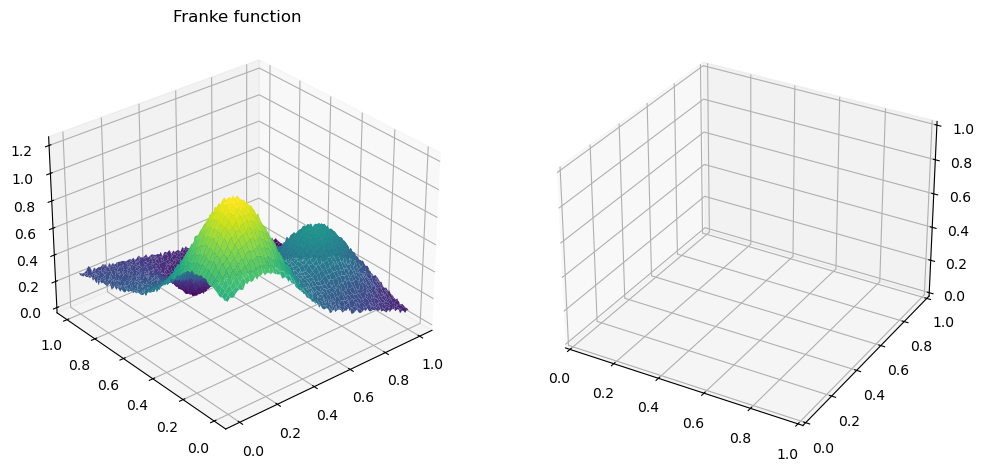

In [17]:
# REshaping for plotting
x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))
z_orig_plot = z.reshape((n,n))

fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke function')
ax.view_init(azim=230)

# Plot the polynomial regression prediction 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Tensorflow Prediction')
ax.view_init(azim=230)

plt.show()